In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
nGauss = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

widths = np.linspace(2, 20, nGauss)

images = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):
    ro = 1.5*np.random.randn(2) # random offset
    G = np.exp( -( (X - ro[0])**2 + (Y - ro[1])**2 ) / (widths[i]) ) # formula for Gaussian

    G = G + np.random.randn(imgSize, imgSize)/5 # adding noise

    # adding a bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))

    if np.random.randn() > 0:
        G[i1:i1+2, ] = 1
    else:
        G[:, i1:i1+i2] = 1

    images[i,:,:,:] = torch.Tensor(G).view(1, imgSize, imgSize)


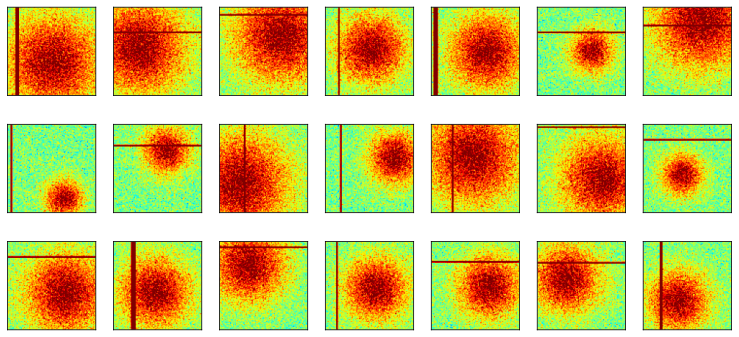

In [3]:
fig, axs = plt.subplots(3, 7, figsize = (13, 6))

for i, ax in enumerate(axs.flatten()):
    whichPic = np.random.randint(nGauss)
    G = np.squeeze(images[whichPic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [4]:
class Model(nn.Module):
    
   def __init__ (self):
      super().__init__()

      self.enc = nn.Sequential(
         nn.Conv2d(1, 6, 3, padding=1),
         nn.ReLU(),
         nn.MaxPool2d(2, 2),
         nn.Conv2d(6, 4, 3, padding=1),
         nn.ReLU(),
         nn.MaxPool2d(2, 2)
      )

      self.dec = nn.Sequential(
         nn.ConvTranspose2d(4, 6, 3, 2),
         nn.ReLU(),
         nn.ConvTranspose2d(6, 1, 3, 2)
      )
    
   def forward(self, x):
      return self.dec(self.enc(x))

In [5]:
def getModel():
    CNN = Model()

    lossFunction = nn.MSELoss()

    optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

    return CNN, lossFunction, optimizer

In [6]:
# testing model

CNN, lossFunction, optimizer = getModel()
yHat = CNN(images[:10,:,:,:])

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)

 
torch.Size([10, 1, 91, 91])


In [7]:
summary(CNN, (1, imgSize, imgSize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

In [8]:
def trainModel(CNN, lossFunction, optimizer):
    epochs = 500

    losses = torch.zeros(epochs)

    for _ in range(epochs):

        pics2use = np.random.choice(nGauss, size=32, replace=False)
        X = images[pics2use,:,:,:]
    
        yHat = CNN.forward(X)
        
        loss = lossFunction(yHat, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses[_] = loss.item()

    return losses, CNN

In [9]:
CNN, lossFunction, optimizer = getModel()
losses, CNN = trainModel(CNN, lossFunction, optimizer)

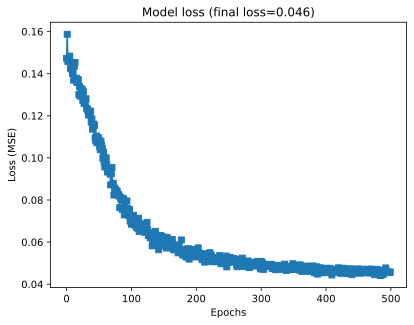

In [10]:
plt.plot(losses, 's-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

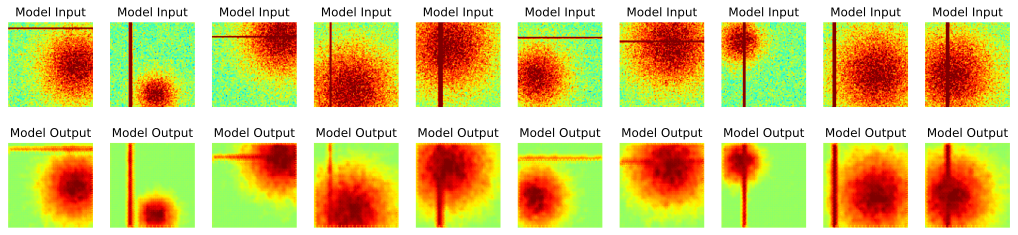

In [11]:
# visualize some images

pics2use = np.random.choice(nGauss, size=32, replace=False)
X = images[pics2use,:,:,:]
yHat = CNN(X)

fig, axs = plt.subplots(2, 10, figsize = (18, 4))

for i in range(10):
    G = torch.squeeze(X[i, 0, :, :]).detach()
    O = torch.squeeze(yHat[i, 0, :, :]).detach()
    axs[0, i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].axis('off')
    axs[0, i].set_title('Model Input')
    
    axs[1, i].imshow(O, vmin=-1, vmax=1, cmap='jet')
    axs[1, i].axis('off')
    axs[1, i].set_title('Model Output')
plt.show()